**Import Necessary Libraries**

In [22]:
# Importing required libraries for data manipulation, model training, and evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Add, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Confirm libraries are loaded
print("Libraries imported successfully.")


Libraries imported successfully.


**Load Dataset**

In [23]:
# Loading dataset from CSV file to analyze and preprocess
data_path = 'Patient_Health_Data.csv'
patient_data = pd.read_csv(data_path)

# Print the first few rows to understand the structure of the data
print("Dataset loaded. Here are the first few rows:")
print(patient_data.head())


Dataset loaded. Here are the first few rows:
  Patient_ID  Height_cm  Weight_kg Blood_Pressure  Temperature_C  Heart_Rate  \
0      P0001      174.0       59.0         120/80           36.6        63.0   
1      P0002        NaN       67.0         130/85           37.0        68.0   
2      P0003      176.0       58.0         140/90           37.0        65.0   
3      P0004      185.0       65.0         125/82           37.2        69.0   
4      P0005      167.0       41.0         135/88           36.3        72.0   

              Symptoms Existing_Conditions      Disease_Predictions  \
0           chest pain            Diabetes            Heart Disease   
1  shortness of breath        Hypertension  Coronary Artery Disease   
2              fatigue    High Cholesterol               Arrhythmia   
3            dizziness                 NaN                      NaN   
4         palpitations              Asthma             Hypertension   

  Laboratory_Test_Results  Cholesterol_mg_dL  B

**Display Data Structure**

In [24]:
print("Dataset structure:")
print(patient_data.info())

Dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient_ID                    2000 non-null   object 
 1   Height_cm                     1915 non-null   float64
 2   Weight_kg                     1914 non-null   float64
 3   Blood_Pressure                1640 non-null   object 
 4   Temperature_C                 1892 non-null   float64
 5   Heart_Rate                    1903 non-null   float64
 6   Symptoms                      1562 non-null   object 
 7   Existing_Conditions           1488 non-null   object 
 8   Disease_Predictions           1488 non-null   object 
 9   Laboratory_Test_Results       1505 non-null   object 
 10  Cholesterol_mg_dL             1899 non-null   float64
 11  Blood_Sugar_mg_dL             1880 non-null   float64
 12  Family_History_Heart_Disease  1891 non-null


Initial Data Overview:
--------------------------------------------------
Dataset shape: (2000, 14)

First few rows of the dataset:


,Patient_ID,Height_cm,Weight_kg,Blood_Pressure,Temperature_C,Heart_Rate,Symptoms,Existing_Conditions,Disease_Predictions,Laboratory_Test_Results,Cholesterol_mg_dL,Blood_Sugar_mg_dL,Family_History_Heart_Disease,Smoking_Status
0,P0001,174.0,59.0,120/80,36.6,63.0,chest pain,Diabetes,Heart Disease,High Cholesterol,198.0,79.0,Yes,Never
1,P0002,NaN,67.0,130/85,37.0,68.0,shortness of breath,Hypertension,Coronary Artery Disease,NaN,179.0,90.0,No,Former
2,P0003,176.0,58.0,140/90,37.0,65.0,fatigue,High Cholesterol,Arrhythmia,Normal,193.0,82.0,NaN,Current
3,P0004,185.0,65.0,125/82,37.2,69.0,dizziness,NaN,NaN,NaN,228.0,103.0,No,Never
4,P0005,167.0,41.0,135/88,36.3,72.0,palpitations,Asthma,Hypertension,NaN,251.0,135.0,Yes,Former



Missing Values Analysis:
--------------------------------------------------
Height_cm                        85
Weight_kg                        86
Blood_Pressure                  360
Temperature_C                   108
Heart_Rate                       97
Symptoms                        438
Existing_Conditions             512
Disease_Predictions             512
Laboratory_Test_Results         495
Cholesterol_mg_dL               101
Blood_Sugar_mg_dL               120
Family_History_Heart_Disease    109
Smoking_Status                   89
dtype: int64


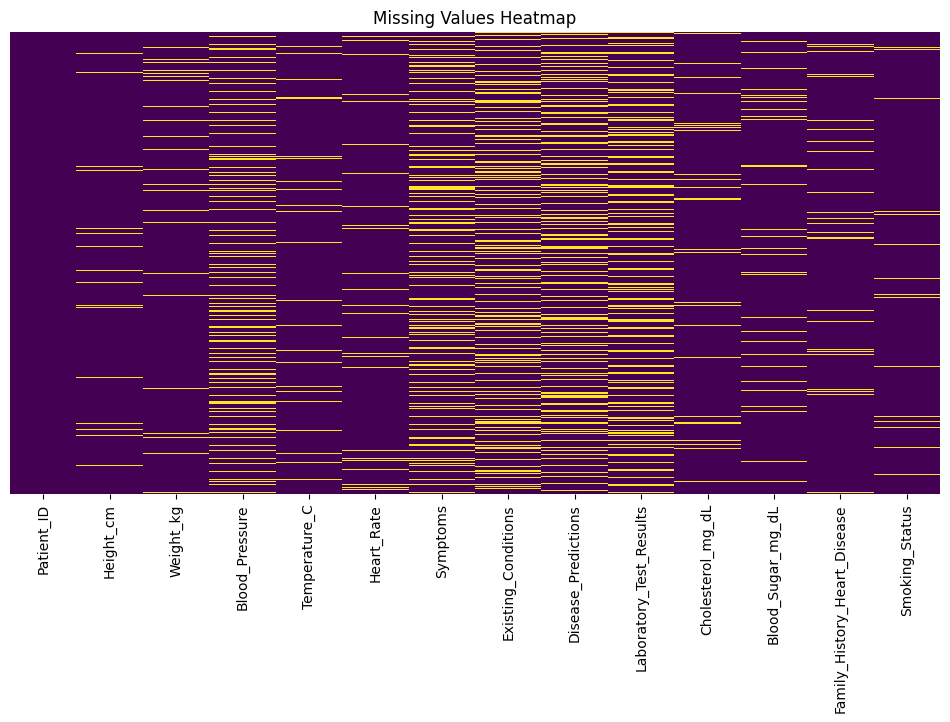

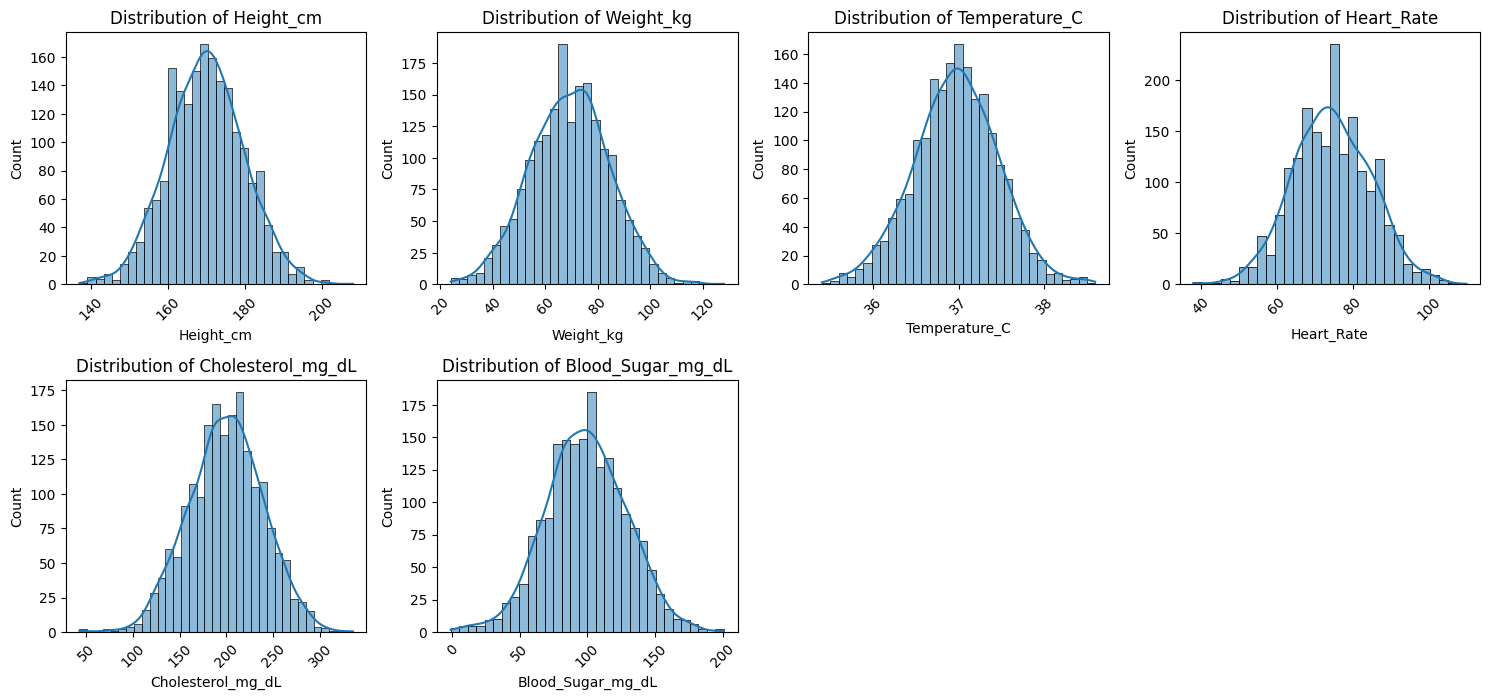

In [25]:
# After loading data
print("\nInitial Data Overview:")
print("-" * 50)
print("Dataset shape:", patient_data.shape)
print("\nFirst few rows of the dataset:")
display(patient_data.head())

# After preprocessing
print("\nMissing Values Analysis:")
print("-" * 50)
missing_values = patient_data.isnull().sum()
print(missing_values[missing_values > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(patient_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Add distribution plots for numerical features
numerical_cols = patient_data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(patient_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Splitting 'Blood_Pressure' Column**

In [26]:
# Split the 'Blood_Pressure' column into 'Systolic_BP' and 'Diastolic_BP'
# This separation helps in individual analysis of each blood pressure component
patient_data[['Systolic_BP', 'Diastolic_BP']] = patient_data['Blood_Pressure'].str.split('/', expand=True)

# Verify the split by viewing the updated DataFrame
print("Blood pressure split into 'Systolic_BP' and 'Diastolic_BP':")
print(patient_data[['Systolic_BP', 'Diastolic_BP']].head())
print(patient_data[['Systolic_BP', 'Diastolic_BP']].info())


Blood pressure split into 'Systolic_BP' and 'Diastolic_BP':
  Systolic_BP Diastolic_BP
0         120           80
1         130           85
2         140           90
3         125           82
4         135           88
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Systolic_BP   1640 non-null   object
 1   Diastolic_BP  1640 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None


**Convert Blood Pressure Columns to Numeric**

In [27]:
# Convert the new blood pressure columns to numeric and handle non-numeric entries by setting them to NaN
# This is necessary for further analysis since we can’t process string values in these columns
patient_data['Systolic_BP'] = pd.to_numeric(patient_data['Systolic_BP'], errors='coerce')
patient_data['Diastolic_BP'] = pd.to_numeric(patient_data['Diastolic_BP'], errors='coerce')

# Check the data types and any potential NaNs introduced during conversion
print("Converted 'Systolic_BP' and 'Diastolic_BP' to numeric types:")
print(patient_data[['Systolic_BP', 'Diastolic_BP']].info())


Converted 'Systolic_BP' and 'Diastolic_BP' to numeric types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Systolic_BP   1640 non-null   float64
 1   Diastolic_BP  1640 non-null   float64
dtypes: float64(2)
memory usage: 31.4 KB
None


**Drop the Original 'Blood_Pressure' Column**

In [28]:
# Drop the original 'Blood_Pressure' column as it is no longer needed
patient_data = patient_data.drop(columns=['Blood_Pressure'])

# Confirm the column is dropped
print("'Blood_Pressure' column dropped:")
print(patient_data.head())

'Blood_Pressure' column dropped:
  Patient_ID  Height_cm  Weight_kg  Temperature_C  Heart_Rate  \
0      P0001      174.0       59.0           36.6        63.0   
1      P0002        NaN       67.0           37.0        68.0   
2      P0003      176.0       58.0           37.0        65.0   
3      P0004      185.0       65.0           37.2        69.0   
4      P0005      167.0       41.0           36.3        72.0   

              Symptoms Existing_Conditions      Disease_Predictions  \
0           chest pain            Diabetes            Heart Disease   
1  shortness of breath        Hypertension  Coronary Artery Disease   
2              fatigue    High Cholesterol               Arrhythmia   
3            dizziness                 NaN                      NaN   
4         palpitations              Asthma             Hypertension   

  Laboratory_Test_Results  Cholesterol_mg_dL  Blood_Sugar_mg_dL  \
0        High Cholesterol              198.0               79.0   
1              

**Fill Missing Values for Numerical Columns**

In [29]:
# Fill missing values in numerical columns with the mean of each column
patient_data.fillna(patient_data.median(numeric_only=True), inplace=True)

# Check for remaining missing values in the DataFrame
print("Filled missing values in numerical columns. Checking for nulls:")
print(patient_data.isnull().sum())


Filled missing values in numerical columns. Checking for nulls:
Patient_ID                        0
Height_cm                         0
Weight_kg                         0
Temperature_C                     0
Heart_Rate                        0
Symptoms                        438
Existing_Conditions             512
Disease_Predictions             512
Laboratory_Test_Results         495
Cholesterol_mg_dL                 0
Blood_Sugar_mg_dL                 0
Family_History_Heart_Disease    109
Smoking_Status                   89
Systolic_BP                       0
Diastolic_BP                      0
dtype: int64


**Fill Missing Values for Categorical Columns**

In [30]:
# Fill missing values in categorical columns with the mode (most frequent value) of each column
for col in patient_data.select_dtypes(include=['object']).columns:
    patient_data[col].fillna(patient_data[col].mode()[0], inplace=True)

# Confirm no missing values remain in categorical columns
print("Filled missing values in categorical columns. Checking for nulls:")
print(patient_data.isnull().sum())


Filled missing values in categorical columns. Checking for nulls:
Patient_ID                      0
Height_cm                       0
Weight_kg                       0
Temperature_C                   0
Heart_Rate                      0
Symptoms                        0
Existing_Conditions             0
Disease_Predictions             0
Laboratory_Test_Results         0
Cholesterol_mg_dL               0
Blood_Sugar_mg_dL               0
Family_History_Heart_Disease    0
Smoking_Status                  0
Systolic_BP                     0
Diastolic_BP                    0
dtype: int64


C:\Users\vaibh\AppData\Local\Temp\ipykernel_32276\1065955776.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  patient_data[col].fillna(patient_data[col].mode()[0], inplace=True)


**Separate Features and Target Variable**

In [31]:
# Separate the features and target variable for model training
X = patient_data.drop(columns=['Disease_Predictions', 'Patient_ID'])
y = patient_data['Disease_Predictions']

# Display the shapes to ensure correct separation
print("Separated features (X) and target (y):")
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Separated features (X) and target (y):
Features shape: (2000, 13)
Target shape: (2000,)


**Encode Target Variable**

In [32]:
# Encode the categorical target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print unique classes to confirm encoding
print("Encoded target variable:")
print("Classes:", label_encoder.classes_)


Encoded target variable:
Classes: ['Arrhythmia' 'Coronary Artery Disease' 'Heart Disease' 'Hypertension'
 'Stroke']


**One-Hot Encode and Standardize Features**

In [33]:
# One-hot encode categorical features and standardize numerical features for better model performance
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Confirm the scaling and encoding by displaying shape and sample data
print("Features encoded and standardized. Sample data:")
print(X_scaled[:5])
print(X_scaled.shape)
# Visualize the first few rows of the scaled and encoded features
pd.DataFrame(X_scaled, columns=X.columns).head()


Features encoded and standardized. Sample data:
[[ 0.42511947 -0.70767243 -0.77023217 -1.14595273 -0.04247373 -0.68912389
  -1.62040061 -1.61665691 -0.38655567 -0.38655567 -0.38740968 -0.73460594
  -0.38655567  2.38515476 -0.41926001 -0.41595736 -0.82845678  2.08508839
  -0.48196047 -0.48038446  1.06511582 -0.68363106  1.46784677]
 [ 0.00971019 -0.16409303  0.05675177 -0.64943941 -0.5368081  -0.31023836
  -0.3207009  -0.31573399 -0.38655567 -0.38655567 -0.38740968 -0.73460594
   2.5869495  -0.41926001 -0.41926001  2.40409256 -0.82845678 -0.47959598
  -0.48196047 -0.48038446 -0.93886503  1.4627773  -0.68127002]
 [ 0.6328241  -0.77561986  0.05675177 -0.9473474  -0.17256172 -0.58579147
   0.9789988   0.98518892 -0.38655567  2.5869495  -0.38740968 -0.73460594
  -0.38655567 -0.41926001  2.38515476 -0.41595736 -0.82845678 -0.47959598
  -0.48196047  2.081666   -0.93886503 -0.68363106 -0.68127002]
 [ 1.56749497 -0.29998788  0.47024374 -0.55013675  0.73805422  0.13753545
  -0.97055076 -1.096287

,Height_cm,Weight_kg,Temperature_C,Heart_Rate,Cholesterol_mg_dL,Blood_Sugar_mg_dL,Systolic_BP,Diastolic_BP,Symptoms_dizziness,Symptoms_fatigue,...,Existing_Conditions_Diabetes,Existing_Conditions_High Cholesterol,Existing_Conditions_Hypertension,Existing_Conditions_Thyroid,Laboratory_Test_Results_High Cholesterol,Laboratory_Test_Results_Low Iron,Laboratory_Test_Results_Normal,Family_History_Heart_Disease_Yes,Smoking_Status_Former,Smoking_Status_Never
0,0.425119,-0.707672,-0.770232,-1.145953,-0.042474,-0.689124,-1.620401,-1.616657,-0.386556,-0.386556,...,2.385155,-0.419260,-0.415957,-0.828457,2.085088,-0.48196,-0.480384,1.065116,-0.683631,1.467847
1,0.009710,-0.164093,0.056752,-0.649439,-0.536808,-0.310238,-0.320701,-0.315734,-0.386556,-0.386556,...,-0.419260,-0.419260,2.404093,-0.828457,-0.479596,-0.48196,-0.480384,-0.938865,1.462777,-0.681270
2,0.632824,-0.775620,0.056752,-0.947347,-0.172562,-0.585791,0.978999,0.985189,-0.386556,2.586949,...,-0.419260,2.385155,-0.415957,-0.828457,-0.479596,-0.48196,2.081666,-0.938865,-0.683631,-0.681270
3,1.567495,-0.299988,0.470244,-0.550137,0.738054,0.137535,-0.970551,-1.096288,2.586949,-0.386556,...,-0.419260,-0.419260,-0.415957,1.207064,-0.479596,-0.48196,-0.480384,-0.938865,-0.683631,1.467847
4,-0.301847,-1.930726,-1.390470,-0.252229,1.336459,1.239748,0.329149,0.464820,-0.386556,-0.386556,...,-0.419260,-0.419260,-0.415957,-0.828457,-0.479596,-0.48196,-0.480384,1.065116,1.462777,-0.681270


**Apply SMOTE to Balance Classes**

In [34]:
# Use SMOTE to balance the classes by oversampling the minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Confirm the balanced classes
print("Applied SMOTE to balance classes. New class distribution:")
print(np.bincount(y_resampled))


Applied SMOTE to balance classes. New class distribution:
[815 815 815 815 815]


**Split into Training and Test Sets**

In [35]:
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3260, 23)
(407, 23)
(408, 23)
(3260,)
(407,)
(408,)


**Model 1: K-Nearest Neighbors (KNN)**

KNN Validation Accuracy: 0.9238329238329238
KNN Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97        95
           1       0.94      0.99      0.96        82
           2       0.94      0.97      0.96        79
           3       0.93      0.70      0.80        82
           4       0.85      0.97      0.91        69

    accuracy                           0.92       407
   macro avg       0.92      0.92      0.92       407
weighted avg       0.93      0.92      0.92       407

KNN Test Accuracy: 0.928921568627451
KNN Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        85
           1       0.95      0.97      0.96        78
           2       0.93      0.97      0.95        73
           3       0.94      0.73      0.82        86
           4       0.88      0.98      0.92        86

    accuracy                    

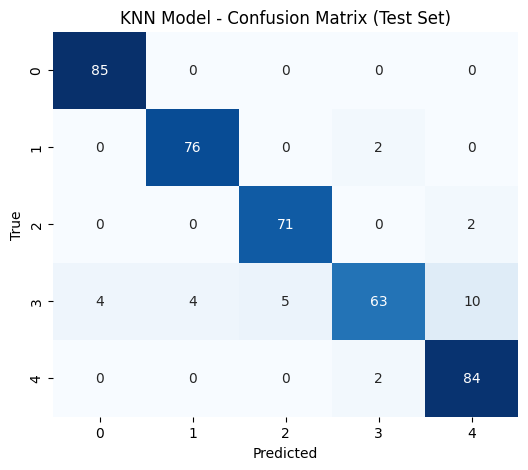

In [36]:
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the validation set
knn_val_pred = knn.predict(X_val)

# Evaluate KNN on the validation set
print("KNN Validation Accuracy:", accuracy_score(y_val, knn_val_pred))
print("KNN Validation Classification Report:\n", classification_report(y_val, knn_val_pred))

# Predict on the test set
knn_test_pred = knn.predict(X_test)

# Evaluate KNN on the test set
print("KNN Test Accuracy:", accuracy_score(y_test, knn_test_pred))
print("KNN Test Classification Report:\n", classification_report(y_test, knn_test_pred))

# Plot confusion matrix for the test set
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, knn_test_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("KNN Model - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Best parameters found by GridSearchCV: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best KNN Validation Accuracy: 0.9238329238329238
Best KNN Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        95
           1       0.95      0.99      0.97        82
           2       0.93      0.97      0.95        79
           3       0.96      0.67      0.79        82
           4       0.82      0.99      0.89        69

    accuracy                           0.92       407
   macro avg       0.92      0.92      0.92       407
weighted avg       0.93      0.92      0.92       407

Best KNN Test Accuracy: 0.9387254901960784
Best KNN Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.94      0.97      0.96        78
           2       0.94      0.99      0.96        73
           3    

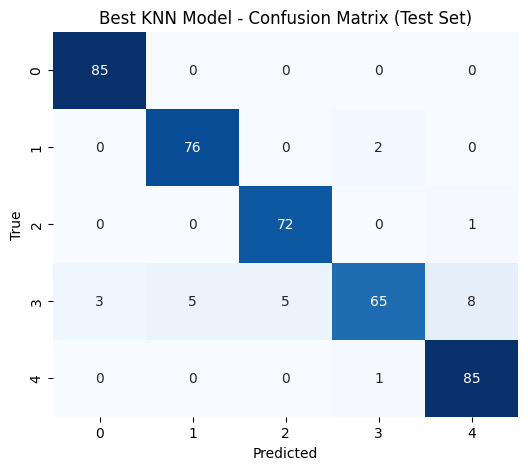

In [37]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found by GridSearchCV:", best_params)

# Predict on the validation set using the best KNN model
knn_val_pred = best_knn.predict(X_val)

# Evaluate the best KNN model on the validation set
print("Best KNN Validation Accuracy:", accuracy_score(y_val, knn_val_pred))
print("Best KNN Validation Classification Report:\n", classification_report(y_val, knn_val_pred))

# Predict on the test set using the best KNN model
knn_test_pred = best_knn.predict(X_test)

# Evaluate the best KNN model on the test set
print("Best KNN Test Accuracy:", accuracy_score(y_test, knn_test_pred))
print("Best KNN Test Classification Report:\n", classification_report(y_test, knn_test_pred))

# Plot confusion matrix for the test set
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, knn_test_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Best KNN Model - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [38]:
import joblib

# Save the trained model
joblib.dump(best_knn, 'knn_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the label encoder
joblib.dump(label_encoder, 'encoder.pkl')

# Save the column names
joblib.dump(list(X.columns), 'columns.pkl')


['columns.pkl']

In [39]:
X.columns

Index(['Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
       'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP',
       'Symptoms_dizziness', 'Symptoms_fatigue', 'Symptoms_nausea',
       'Symptoms_palpitations', 'Symptoms_shortness of breath',
       'Existing_Conditions_Diabetes', 'Existing_Conditions_High Cholesterol',
       'Existing_Conditions_Hypertension', 'Existing_Conditions_Thyroid',
       'Laboratory_Test_Results_High Cholesterol',
       'Laboratory_Test_Results_Low Iron', 'Laboratory_Test_Results_Normal',
       'Family_History_Heart_Disease_Yes', 'Smoking_Status_Former',
       'Smoking_Status_Never'],
      dtype='object')

In [40]:
import pandas as pd
import numpy as np
import joblib

# Load the saved model, scaler, encoder, and column names
model = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('encoder.pkl')
columns = joblib.load('columns.pkl')  # Assuming this includes the feature columns

# Define a sample input based on the feature columns
sample_input = {
    'Height_cm': 170,
    'Weight_kg': 70,
    'Temperature_C': 36.5,
    'Heart_Rate': 72,
    'Cholesterol_mg_dL': 180,
    'Blood_Sugar_mg_dL': 95,
    'Systolic_BP': 120,
    'Diastolic_BP': 80,
    'Symptoms_dizziness': 0,
    'Symptoms_fatigue': 1,
    'Symptoms_nausea': 0,
    'Symptoms_palpitations': 0,
    'Symptoms_shortness of breath': 0,
    'Existing_Conditions_Diabetes': 0,
    'Existing_Conditions_High Cholesterol': 1,
    'Existing_Conditions_Hypertension': 0,
    'Existing_Conditions_Thyroid': 0,
    'Laboratory_Test_Results_High Cholesterol': 1,
    'Laboratory_Test_Results_Low Iron': 0,
    'Laboratory_Test_Results_Normal': 0,
    'Family_History_Heart_Disease_Yes': 1,
    'Smoking_Status_Former': 0,
    'Smoking_Status_Never': 1,
}

# Convert the input into a DataFrame
sample_df = pd.DataFrame([sample_input])

# Define a sample input based on the feature columns
sample_input = {
    'Height_cm': 170,
    'Weight_kg': 70,
    'Temperature_C': 36.5,
    'Heart_Rate': 72,
    'Cholesterol_mg_dL': 180,
    'Blood_Sugar_mg_dL': 95,
    'Systolic_BP': 120,
    'Diastolic_BP': 80,
    'Symptoms_dizziness': 0,
    'Symptoms_fatigue': 1,
    'Symptoms_nausea': 0,
    'Symptoms_palpitations': 0,
    'Symptoms_shortness of breath': 0,
    'Existing_Conditions_Diabetes': 0,
    'Existing_Conditions_High Cholesterol': 1,
    'Existing_Conditions_Hypertension': 0,
    'Existing_Conditions_Thyroid': 0,
    'Laboratory_Test_Results_High Cholesterol': 1,
    'Laboratory_Test_Results_Low Iron': 0,
    'Laboratory_Test_Results_Normal': 0,
    'Family_History_Heart_Disease_Yes': 1,
    'Smoking_Status_Former': 0,
    'Smoking_Status_Never': 1,
}

# Convert the input into a DataFrame
sample_df = pd.DataFrame([sample_input])


# Add missing columns and initialize them to 0
for col in columns:
    if col not in sample_df.columns:
        sample_df[col] = 0

# Ensure the order of columns matches the training data
sample_df = sample_df[columns]

# Scale the input data
sample_scaled = scaler.transform(sample_df)

# Predict the encoded label
predicted_label_encoded = model.predict(sample_scaled)

# Decode the label back to the original class
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

# Display the result
print(f"Sample Input: {sample_input}")
print(f"Predicted Disease: {predicted_label[0]}")


Sample Input: {'Height_cm': 170, 'Weight_kg': 70, 'Temperature_C': 36.5, 'Heart_Rate': 72, 'Cholesterol_mg_dL': 180, 'Blood_Sugar_mg_dL': 95, 'Systolic_BP': 120, 'Diastolic_BP': 80, 'Symptoms_dizziness': 0, 'Symptoms_fatigue': 1, 'Symptoms_nausea': 0, 'Symptoms_palpitations': 0, 'Symptoms_shortness of breath': 0, 'Existing_Conditions_Diabetes': 0, 'Existing_Conditions_High Cholesterol': 1, 'Existing_Conditions_Hypertension': 0, 'Existing_Conditions_Thyroid': 0, 'Laboratory_Test_Results_High Cholesterol': 1, 'Laboratory_Test_Results_Low Iron': 0, 'Laboratory_Test_Results_Normal': 0, 'Family_History_Heart_Disease_Yes': 1, 'Smoking_Status_Former': 0, 'Smoking_Status_Never': 1}
Predicted Disease: Arrhythmia


In [41]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier  # Example model, replace with yours
import joblib  # To load the saved model

# Load the trained model
model = joblib.load('knn_model.pkl')  # Replace 'your_model.pkl' with your actual file name

# Define feature names in the same order as used in training
feature_names = [
    'Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
    'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP',
    'Symptoms_dizziness', 'Symptoms_fatigue', 'Symptoms_nausea',
    'Symptoms_palpitations', 'Symptoms_shortness of breath',
    'Existing_Conditions_Diabetes', 'Existing_Conditions_High Cholesterol',
    'Existing_Conditions_Hypertension', 'Existing_Conditions_Thyroid',
    'Laboratory_Test_Results_High Cholesterol',
    'Laboratory_Test_Results_Low Iron', 'Laboratory_Test_Results_Normal',
    'Family_History_Heart_Disease_Yes', 'Smoking_Status_Former',
    'Smoking_Status_Never'
]

# Define a function to create input data
def create_input_data(input_dict):
    # Initialize input with zeros for all categorical features
    input_data = {col: 0 for col in feature_names}

    # Fill in provided inputs (numerical and categorical)
    for key, value in input_dict.items():
        if key in input_data:
            input_data[key] = value

    # Ensure the order matches the training feature names
    input_array = [input_data[feature] for feature in feature_names]
    return np.array(input_array).reshape(1, -1)

# Example input: You can adjust this dictionary with your input values
input_dict = {
    'Height_cm': 170,
    'Weight_kg': 70,
    'Temperature_C': 36.5,
    'Heart_Rate': 72,
    'Cholesterol_mg_dL': 200,
    'Blood_Sugar_mg_dL': 100,
    'Systolic_BP': 120,
    'Diastolic_BP': 80,
    'Symptoms_fatigue': 1,  # One symptom active
    'Existing_Conditions_Hypertension': 1,  # One condition active
    'Laboratory_Test_Results_Normal': 1,  # One test result active
    'Family_History_Heart_Disease_Yes': 1,  # Family history active
    'Smoking_Status_Never': 1  # Smoking status active
}

# Create input data aligned with training data format
input_data = create_input_data(input_dict)

# Make prediction
prediction = model.predict(input_data)
prediction_proba = model.predict_proba(input_data)  # If probabilities are needed

# Display results
print("Prediction:", prediction[0])  # Adjust output based on your model
print("Prediction Probabilities:", prediction_proba)

Prediction: 2
Prediction Probabilities: [[0.        0.        0.6001011 0.3998989 0.       ]]


In [42]:
import numpy as np
import pandas as pd
import joblib  # For loading saved models, encoders, and scalers

# Load the trained model, scaler, and label encoder
model = joblib.load('knn_model.pkl')  # Replace with your actual model file name
scaler = joblib.load('scaler.pkl')  # Replace with your scaler file name
label_encoder = joblib.load('encoder.pkl')  # Replace with your label encoder file name

# Define feature names in the same order as used in training
feature_names = [
    'Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
    'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP',
    'Symptoms_dizziness', 'Symptoms_fatigue', 'Symptoms_nausea',
    'Symptoms_palpitations', 'Symptoms_shortness of breath',
    'Existing_Conditions_Diabetes', 'Existing_Conditions_High Cholesterol',
    'Existing_Conditions_Hypertension', 'Existing_Conditions_Thyroid',
    'Laboratory_Test_Results_High Cholesterol',
    'Laboratory_Test_Results_Low Iron', 'Laboratory_Test_Results_Normal',
    'Family_History_Heart_Disease_Yes', 'Smoking_Status_Former',
    'Smoking_Status_Never'
]

# Define a function to preprocess input data
def preprocess_input(input_dict):
    """
    Preprocess the input dictionary:
    - Apply label encoding for categorical features.
    - Normalize numerical features using the loaded scaler.
    """
    # Initialize input data with default values (zeros)
    input_data = {col: 0 for col in feature_names}

    # Fill in provided inputs
    for key, value in input_dict.items():
        if key in input_data:
            input_data[key] = value

    # Convert to DataFrame for easier manipulation
    input_df = pd.DataFrame([input_data])

    # Separate categorical and numerical features
    categorical_cols = [
        'Symptoms_dizziness', 'Symptoms_fatigue', 'Symptoms_nausea',
        'Symptoms_palpitations', 'Symptoms_shortness of breath',
        'Existing_Conditions_Diabetes', 'Existing_Conditions_High Cholesterol',
        'Existing_Conditions_Hypertension', 'Existing_Conditions_Thyroid',
        'Laboratory_Test_Results_High Cholesterol',
        'Laboratory_Test_Results_Low Iron', 'Laboratory_Test_Results_Normal',
        'Family_History_Heart_Disease_Yes', 'Smoking_Status_Former',
        'Smoking_Status_Never'
    ]
    numerical_cols = [
        'Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
        'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP'
    ]

    # Apply label encoding for categorical features
    for col in categorical_cols:
        if col in input_df.columns:
            input_df[col] = label_encoder.transform(input_df[col]) if col in input_dict else 0

    # Apply scaling for numerical features
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

    # Ensure order matches feature names used during training
    processed_data = input_df[feature_names].values

    return processed_data

# Example input: Update this with real values
input_dict = {
    'Height_cm': 170,
    'Weight_kg': 70,
    'Temperature_C': 36.5,
    'Heart_Rate': 72,
    'Cholesterol_mg_dL': 200,
    'Blood_Sugar_mg_dL': 100,
    'Systolic_BP': 120,
    'Diastolic_BP': 80,
    'Symptoms_fatigue': 1,  # Example categorical feature
    'Existing_Conditions_Hypertension': 1,  # Example categorical feature
    'Laboratory_Test_Results_Normal': 1,  # Example categorical feature
    'Family_History_Heart_Disease_Yes': 1,  # Example categorical feature
    'Smoking_Status_Never': 1  # Example categorical feature
}

# Preprocess input data
input_data = preprocess_input(input_dict)

# Make prediction
prediction = model.predict(input_data)
prediction_proba = model.predict_proba(input_data)  # If probabilities are needed

# Display results
print("Prediction:", prediction[0])  # Adjust output format based on your model
print("Prediction Probabilities:", prediction_proba)


ValueError: y contains previously unseen labels: 1

In [ ]:
import numpy as np
import pandas as pd
import joblib  # For loading saved models, encoders, and scalers

# Load the trained model, scaler, and label encoder
model = joblib.load('knn_model.pkl')  # Replace with your actual model file name
scaler = joblib.load('scaler.pkl')  # Replace with your scaler file name
label_encoder = joblib.load('encoder.pkl')  # Replace with your label encoder file name

# Define feature names in the same order as used in training
feature_names = [
    'Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
    'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP',
    'Symptoms_dizziness', 'Symptoms_fatigue', 'Symptoms_nausea',
    'Symptoms_palpitations', 'Symptoms_shortness of breath',
    'Existing_Conditions_Diabetes', 'Existing_Conditions_High Cholesterol',
    'Existing_Conditions_Hypertension', 'Existing_Conditions_Thyroid',
    'Laboratory_Test_Results_High Cholesterol',
    'Laboratory_Test_Results_Low Iron', 'Laboratory_Test_Results_Normal',
    'Family_History_Heart_Disease_Yes', 'Smoking_Status_Former',
    'Smoking_Status_Never'
]

# Categorical columns mapping
symptom_options = ['chest pain', 'shortness of breath', 'fatigue', 'dizziness', 'palpitations', 'nausea']
existing_conditions_options = ['Diabetes', 'High Cholesterol', 'Hypertension', 'Thyroid']
laboratory_test_results_options = ['High Cholesterol', 'Low Iron', 'Normal']
smoking_status_options = ['Former', 'Never']
family_history_options = ['Heart Disease']

# Function to preprocess input data
def preprocess_input(input_dict):
    """
    Preprocess the input dictionary:
    - Apply label encoding for categorical features.
    - Normalize numerical features using the loaded scaler.
    """
    # Initialize input data with default values (zeros)
    input_data = {col: 0 for col in feature_names}

    # Update input_data with the provided inputs
    for key, value in input_dict.items():
        if key in input_data:
            input_data[key] = value

    # Convert to DataFrame for easier manipulation
    input_df = pd.DataFrame([input_data])

    # Process Symptoms - handle all symptom columns (set 1 for the chosen symptom, 0 for others)
    for symptom in symptom_options:
        column_name = f'Symptoms_{symptom.replace(" ", "_")}'
        if column_name in input_dict:
            input_df[column_name] = 1
        else:
            input_df[column_name] = 0

    # Process Existing Conditions - handle each condition (1 for "Yes", 0 for "No")
    for condition in existing_conditions_options:
        column_name = f'Existing_Conditions_{condition.replace(" ", "_")}'
        if column_name in input_dict and input_dict[column_name] == 'Yes':
            input_df[column_name] = 1
        else:
            input_df[column_name] = 0

    # Process Laboratory Test Results - similarly handle each lab result
    for result in laboratory_test_results_options:
        column_name = f'Laboratory_Test_Results_{result.replace(" ", "_")}'
        if column_name in input_dict and input_dict[column_name] == 'Yes':
            input_df[column_name] = 1
        else:
            input_df[column_name] = 0

    # Process Smoking Status - handle the binary columns for smoking status
    for status in smoking_status_options:
        column_name = f'Smoking_Status_{status}'
        if column_name in input_dict and input_dict[column_name] == 'Yes':
            input_df[column_name] = 1
        else:
            input_df[column_name] = 0

    # Process Family History - handle the binary column for family history of heart disease
    for history in family_history_options:
        column_name = f'Family_History_Heart_Disease_Yes'
        if column_name in input_dict and input_dict[column_name] == 'Yes':
            input_df[column_name] = 1
        else:
            input_df[column_name] = 0

    # Apply scaling for numerical features
    numerical_cols = [
        'Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
        'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP'
    ]
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

    # Ensure the order matches the training data feature names
    processed_data = input_df[feature_names].values

    return processed_data

# Example input: User selects symptoms and conditions
input_dict = {
    'Height_cm': 170,
    'Weight_kg': 70,
    'Temperature_C': 36.5,
    'Heart_Rate': 72,
    'Cholesterol_mg_dL': 200,
    'Blood_Sugar_mg_dL': 100,
    'Systolic_BP': 120,
    'Diastolic_BP': 80,
    'Symptoms_chest_pain': 'Yes',  # User-selected symptom
    'Existing_Conditions_Diabetes': 'Yes',  # User-selected condition
    'Laboratory_Test_Results_High_Cholesterol': 'Yes',  # User-selected lab result
    'Family_History_Heart_Disease_Yes': 'Yes',  # Family history
    'Smoking_Status_Former': 'Yes'  # Smoking status
}

# Preprocess input data
input_data = preprocess_input(input_dict)

# Make prediction
prediction = model.predict(input_data)
prediction_proba = model.predict_proba(input_data)  # If probabilities are needed

# Display results
print("Prediction:", prediction[0])  # Adjust output format based on your model
print("Prediction Probabilities:", prediction_proba)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Existing_Conditions_Diabetes
- Existing_Conditions_High Cholesterol
- Existing_Conditions_Hypertension
- Existing_Conditions_Thyroid
- Family_History_Heart_Disease_Yes
- ...


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define your feature names as they were used during training
numerical_cols = [
    'Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
    'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP'
]
categorical_cols = [
    'Symptoms', 'Existing_Conditions', 'Laboratory_Test_Results',
    'Smoking_Status', 'Family_History_Heart_Disease'
]

# Example preprocessing function to match feature names
def preprocess_input(input_dict):
    # Convert input_dict into a DataFrame
    input_df = pd.DataFrame([input_dict])
    
    # One-hot encode categorical columns
    input_df = pd.get_dummies(input_df, columns=categorical_cols, drop_first=True)
    
    # Apply scaling for numerical columns (ensure scaler was fitted during training)
    numerical_cols = [
        'Height_cm', 'Weight_kg', 'Temperature_C', 'Heart_Rate',
        'Cholesterol_mg_dL', 'Blood_Sugar_mg_dL', 'Systolic_BP', 'Diastolic_BP'
    ]
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])

    # Ensure the order of columns matches the trained model
    input_df = input_df[feature_names]  # Use the feature names from your model training

    return input_df

# Example input dictionary
input_dict = {
    'Height_cm': 170,
    'Weight_kg': 70,
    'Temperature_C': 37,
    'Heart_Rate': 75,
    'Cholesterol_mg_dL': 200,
    'Blood_Sugar_mg_dL': 100,
    'Systolic_BP': 120,
    'Diastolic_BP': 80,
    'Symptoms': 'chest pain',  # Example symptom
    'Existing_Conditions': 'Diabetes',  # Example condition
    'Laboratory_Test_Results': 'High Cholesterol',
    'Smoking_Status': 'Former',
    'Family_History_Heart_Disease': 'Yes'
}

# Make sure to preprocess the input before passing it to the model
input_data = preprocess_input(input_dict)

# Now, you can pass this processed data to your trained model for prediction
prediction = model.predict(input_data)
print(prediction)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Existing_Conditions_Diabetes
- Existing_Conditions_High Cholesterol
- Existing_Conditions_Hypertension
- Existing_Conditions_Thyroid
- Family_History_Heart_Disease_Yes
- ...


# **TRY this & allign to your project**

In [43]:
import pandas as pd
import joblib

# Load the trained model, scaler, and column names
knn_model = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler.pkl')
train_columns = joblib.load('columns.pkl')  # Load saved columns
label_encoder = joblib.load('encoder.pkl')  # Load saved label encoder

# Define a sample input (example values provided; adjust as needed)
sample_data = {
    "Height_cm": 170,
    "Weight_kg": 70,
    "Temperature_C": 37,
    "Heart_Rate": 75,
    "Cholesterol_mg_dL": 180,
    "Blood_Sugar_mg_dL": 95,
    "Systolic_BP": 120,
    "Diastolic_BP": 80,
    "Symptoms": "chest pain",  # Example categorical value
    "Existing_Conditions": "Diabetes",
    "Laboratory_Test_Results": "Normal",
    "Smoking_Status": "Never",
    "Family_History_Heart_Disease": "Yes"
}

# Convert the sample data to a DataFrame
sample_df = pd.DataFrame([sample_data])

# Apply one-hot encoding to the categorical columns
categorical_columns = [
    "Symptoms",
    "Existing_Conditions",
    "Laboratory_Test_Results",
    "Smoking_Status",
    "Family_History_Heart_Disease"
]

# Apply one-hot encoding to categorical columns using pandas get_dummies
sample_df = pd.get_dummies(sample_df, columns=categorical_columns)

# Add missing columns (those that were present in the training dataset but not in the sample input)
for col in train_columns:
    if col not in sample_df.columns:
        sample_df[col] = 0  # Add missing columns with default values (0 for binary columns)

# Reorder columns to match the training data columns
sample_df = sample_df[train_columns]

# Scale the numerical data using the loaded scaler
scaled_input = scaler.transform(sample_df.values)

# Predict using the trained KNN model
prediction = knn_model.predict(scaled_input)

# If the output is encoded, use the label encoder to decode the prediction
predicted_label = label_encoder.inverse_transform(prediction)

# Output the prediction
print("Predicted Disease:", predicted_label[0])

Predicted Disease: Heart Disease


d:\HEART_DISEASE_PREDICTION\hdp\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
